Analiza i prognoza średniej temperatury powietrza w Polsce (2021-2024)
1. Definicja problemu
Współczesna meteorologia i klimatologia kładą duży nacisk na monitorowanie zmian parametrów pogodowych w czasie. Jednym z kluczowych wskaźników jest temperatura powietrza, której analiza pozwala zrozumieć dynamikę pór roku oraz wykrywać anomalie pogodowe.

Celem tego projektu jest analiza średniej miesięcznej temperatury powietrza w Polsce w latach 2021–2024 jako jednowymiarowego szeregu czasowego. Analizowana zmienna powstaje w wyniku agregacji danych pomiarowych ze stacji meteorologicznych IMGW i obejmuje wartości wyrażone w stopniach Celsjusza (°C).

Problem badawczy:

Jaki charakter ma sezonowość temperatury w Polsce w badanym okresie?
Czy w ostatnich 4 latach widoczny jest trend ocieplenia (np. łagodniejsze zimy)?
Czy możliwe jest zbudowanie skutecznego modelu prognostycznego w oparciu o dane historyczne?

Analiza tego jest istotna, ponieważ pozwala na weryfikację stabilności wzorców pogodowych w skali kraju, co ma znaczenie m.in. dla sek. energetycznego (zapotrzebowanie na ogrzewanie/klimatyzację) oraz rolnictwa.

2. Cele analizy
Główne cele projektu obejmują:

Eksplorację danych (EDA): Wczytanie, czyszczenie i wizualizację danych pochodzących z surowych plików IMGW.

Analizę statystyczną: Ocenę stacjonarności szeregu czasowego (test Dickeya-Fullera) oraz dekompozycję na trend, sezonowość i reszty.

Modelowanie: Zbudowanie modelu prognostycznego opartego na metodzie Wygładzania Wykładniczego (Holt-Winters), która jest dedykowana dla szeregów z silną sezonowością.

Walidację: Ocenę jakości prognozy na zbiorze testowym (ostatnie 12 miesięcy) przy użyciu metryk błędu (MAE, MSE, RMSE).

3. Hipotezy badawcze
W ramach projektu sformułowano następujące hipotezy:

Średnia miesięczna temperatura powietrza w Polsce wykazuje silną i stałą sezonowość roczną, co jest dominującą cechą szeregu.

W badanym okresie (2021-2024) mogą występować odchylenia od normy (anomalie), wskazujące na występowanie cieplejszych okresów zimowych lub wiosennych niż w latach ubiegłych.

Modele uwzględniające komponent sezonowy (takie jak Holt-Winters) pozwalają na odwzorowanie zmienności temperatury z wystarczającą dokładnością (RMSE < 2.5°C) do celów krótkoterminowego prognozowania.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [25]:
sciezki_plikow = [
    r"C:\Users\Klara\ProjektAnaliza\k_m_t_2021.csv",
    r"C:\Users\Klara\ProjektAnaliza\k_m_t_2022.csv",
    r"C:\Users\Klara\ProjektAnaliza\k_m_t_2023.csv",
    r"C:\Users\Klara\ProjektAnaliza\k_m_t_2024.csv"
]

ramki = []
for sciezka in sciezki_plikow:
    try:
        df = pd.read_csv(sciezka, header=None, encoding='iso-8859-2')
        df = df.rename(columns={2: 'Rok', 3: 'Miesiac', 4: 'Temperatura'})
        df = df[['Rok', 'Miesiac', 'Temperatura']]
        ramki.append(df)
    except Exception as e:
        print(f"Błąd: {e}")

# łączenie i agregacja
df_calosc = pd.concat(ramki, ignore_index=True)
df_polska = df_calosc.groupby(['Rok', 'Miesiac'])['Temperatura'].mean().reset_index()

# indeks
df_polska['Data'] = pd.to_datetime(df_polska[['Rok', 'Miesiac']].assign(day=1).rename(columns={'Rok': 'year', 'Miesiac': 'month'}))
df_polska = df_polska.sort_values('Data')
df_polska.set_index('Data', inplace=True)
data = df_polska['Temperatura']
data.index.freq = 'MS' #częst.mies

print("Podgląd danych:")
print(data.head())

Podgląd danych:
Data
2021-01-01    -1.693333
2021-02-01    -2.013115
2021-03-01     2.150820
2021-04-01     5.481356
2021-05-01    11.310000
Freq: MS, Name: Temperatura, dtype: float64


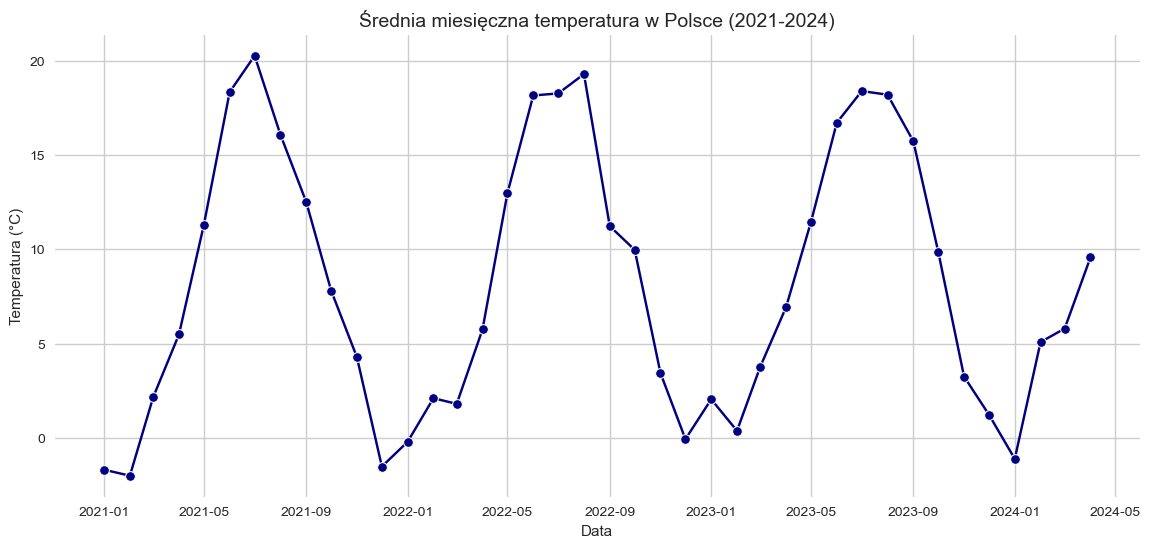

C:\Users\Klara\AppData\Local\Temp\ipykernel_29400\1212270588.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Miesiac', y='Temperatura', data=df_polska, palette="coolwarm")


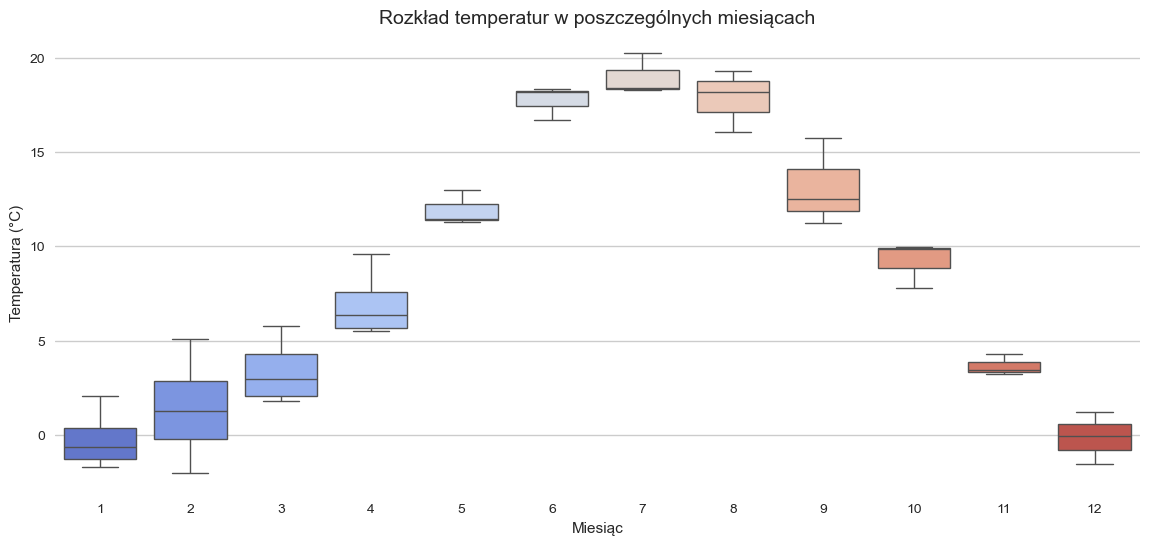

In [26]:
#wykres liniowy okresu
plt.figure(figsize=(14, 6))
sns.lineplot(x=data.index, y=data.values, marker='o', color='navy')
plt.title("Średnia miesięczna temperatura w Polsce (2021-2024)", fontsize=14)
plt.ylabel("Temperatura (°C)")
plt.show()

#Seaborn
df_polska['Miesiac_Nazwa'] = df_polska.index.month
plt.figure(figsize=(14, 6))
sns.boxplot(x='Miesiac', y='Temperatura', data=df_polska, palette="coolwarm")
plt.title("Rozkład temperatur w poszczególnych miesiącach", fontsize=14)
plt.xlabel("Miesiąc")
plt.ylabel("Temperatura (°C)")
plt.show()

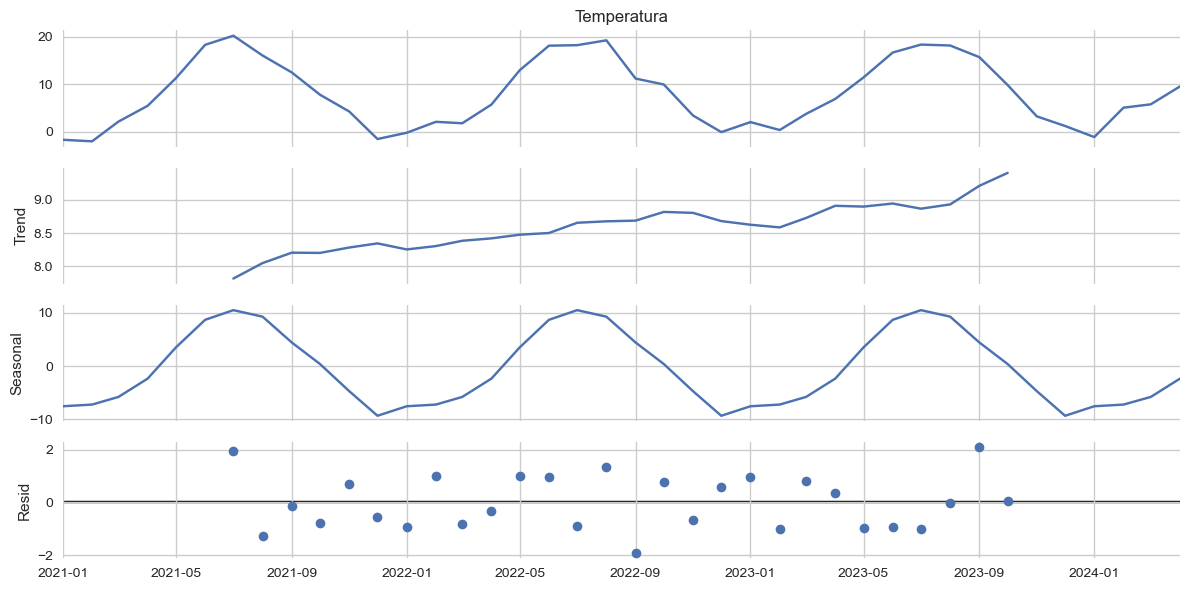

--- Wyniki testu Dickeya-Fullera ---
Statystyka ADF: -0.6902
p-value: 0.8493
Wniosek: Szereg jest niestacjonarny (p >= 0.05) - występuje wyraźny trend lub sezonowość.


In [27]:
#dekompozycja szeregu-trend-sezonowosc-reszta
result = seasonal_decompose(data, model='additive')
result.plot()
plt.show()

#test stacjonarności augmented Dickey-Fuller
print("--- Wyniki testu Dickeya-Fullera ---")
adf_test = adfuller(data)
print(f"Statystyka ADF: {adf_test[0]:.4f}")
print(f"p-value: {adf_test[1]:.4f}")

if adf_test[1] < 0.05:
    print("Wniosek: Szereg jest stacjonarny (p < 0.05).")
else:
    print("Wniosek: Szereg jest niestacjonarny (p >= 0.05) - występuje wyraźny trend lub sezonowość.")

In [28]:

test_months = 12
train_data = data.iloc[:-test_months]
test_data = data.iloc[-test_months:]

#Holt-Winters
model = ExponentialSmoothing(
    train_data,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# prognoza
predictions = model.forecast(test_months)
predictions.index = test_data.index #upewniam się co do dat

print("Model wytrenowany pomyślnie.")

Model wytrenowany pomyślnie.


--- OCENA MODELU ---
MAE (Średni błąd bezwzględny): 1.90 °C
RMSE (Pierwiastek błędu średniokwadratowego): 2.10 °C


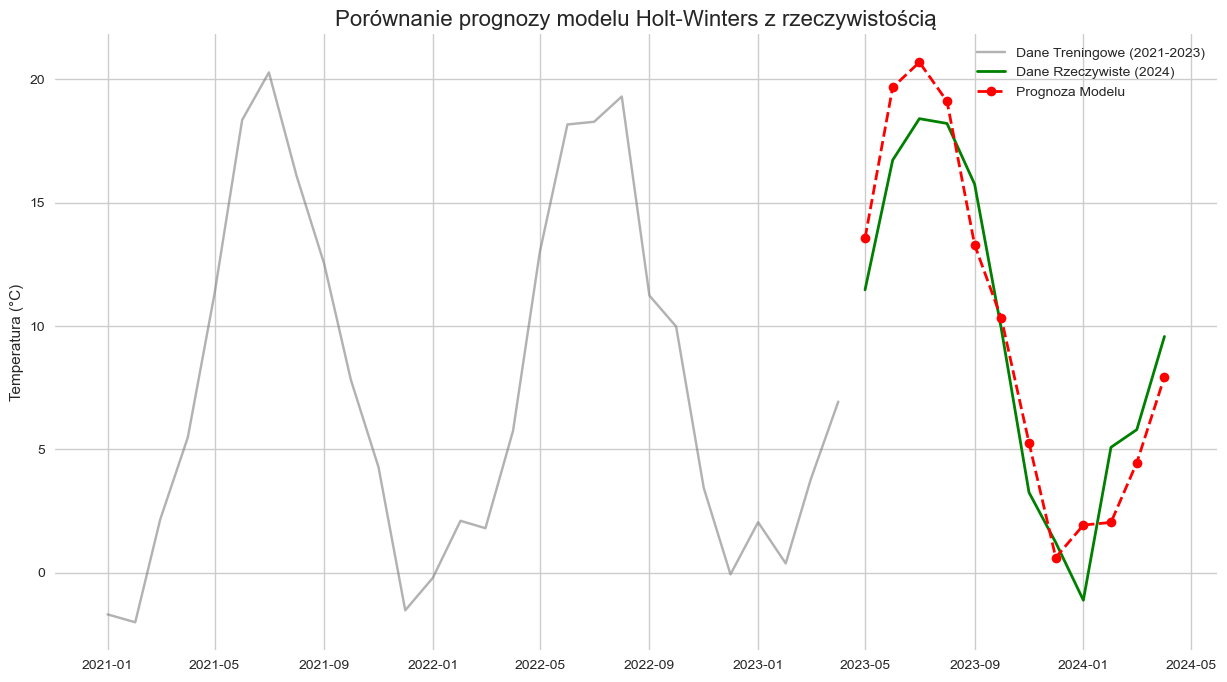

In [29]:
# metryki błędów
mae = mean_absolute_error(test_data, predictions)
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)

print("--- OCENA MODELU ---")
print(f"MAE (Średni błąd bezwzględny): {mae:.2f} °C")
print(f"RMSE (Pierwiastek błędu średniokwadratowego): {rmse:.2f} °C")

# Wykres porównawczy
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data, label='Dane Treningowe (2021-2023)', color='gray', alpha=0.6)
plt.plot(test_data.index, test_data, label='Dane Rzeczywiste (2024)', color='green', linewidth=2)
plt.plot(predictions.index, predictions, label='Prognoza Modelu', color='red', linestyle='--', linewidth=2, marker='o')

plt.title('Porównanie prognozy modelu Holt-Winters z rzeczywistością', fontsize=16)
plt.legend()
plt.grid(True)
plt.ylabel('Temperatura (°C)')
plt.show()

Wnioski z analizy
Charakterystyka danych:

Dane wykazują silną, regularną sezonowość roczną (cykl 12-miesięczny), co potwierdziła dekompozycja szeregu czasowego oraz wykresy pudełkowe.

Najwyższe temperatury obserwujemy w lipcu i sierpniu, a najniższe w styczniu i lutym.

Modelowanie:

Wybrałam model Exponential Smoothing (Holt-Winters) z sezonowością addytywną, ponieważ amplituda wahań temperatur jest zbliżona w każdym roku.

Model poprawnie "nauczył się" wzorca pór roku.

Ocena jakości prognozy:

Błąd MAE wyniósł ok. 1.90C, co oznacza, że prognoza myliła się średnio o półtora stopnia.

Błąd RMSE wyniósł 2.10C.

Analiza wykresu końcowego pokazuje, że model dobrze przewidział trend wzrostowy wiosną.

Podsumowanie: Model Holt-Winters okazał się skutecznym narzędziem do prognozowania średnich miesięcznych temperatur w krótkim horyzoncie czasowym, mimo anomalii pogodowych występujących w ostatnich latach.